# SQL Injection Detection using Machine Learning

In [1]:
%pip install seaborn
%pip install nltk
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
# importing required libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

ModuleNotFoundError: No module named 'xgboost'

## Reading sql data file 

In [3]:
#df = pd.read_csv(r'C:\Users\Dell\Desktop\SQLInjectionML\dataset\sqlCleaned.csv', encoding = 'utf-16') # Read the dataset.
df = pd.read_csv(r'/kaggle/input/sqlinjestionml/sql_30k.csv') # Read the dataset.
df.head(10)

,Sentence,Label,Unnamed: 2,Unnamed: 3
0,""" or pg_sleep ( __TIME__ ) --""",1,NaN,NaN
1,create user name identified by pass123 tempora...,1,NaN,NaN
2,AND 1 = utl_inaddr.get_host_address ( ...,1,NaN,NaN
3,select * from users where id = '1' or @ @1 ...,1,NaN,NaN
4,select 2a from users where id = '1' or @ @1...,1,NaN,NaN
5,73656c656374202a2066726f6d2075736572732077686...,1,NaN,NaN
6,"select * from users where id = 1 or 1#"" ( ...",1,NaN,NaN
7,select name from syscolumns where id = ...,1,NaN,NaN
8,select * from users where id = 1 +$+ or 1 =...,1,NaN,NaN
9,"1; ( load_file ( char ( 47,101,116,99,47...",1,NaN,NaN


## Shape of Dataframe

In [4]:
df.shape

(30931, 4)

In [5]:
df.drop(["Unnamed: 2","Unnamed: 3"], axis=1, inplace=True)

In [6]:
df

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --""",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,select 2a from users where id = '1' or @ @1...,1
...,...,...
30926,DELETE FROM door WHERE grow = 'small',0
30927,DELETE FROM tomorrow,0
30928,SELECT wide ( s ) FROM west,0
30929,SELECT * FROM ( SELECT slide FROM breath ),0


## Dataframe column information 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30931 entries, 0 to 30930
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  30919 non-null  object
 1   Label     30931 non-null  object
dtypes: object(2)
memory usage: 483.4+ KB


## Describe Dataframe 

In [8]:
df.describe(include="all")

,Sentence,Label
count,30919,30931
unique,30891,14
top,#NAME?,0
freq,8,19547


## Describe Label column 

In [9]:
df['Label'].describe()

count     30931
unique       14
top           0
freq      19547
Name: Label, dtype: object

## Check null values 

In [10]:
df.isna().sum()

Sentence    12
Label        0
dtype: int64

## Drop null values 

In [11]:
df.dropna(inplace=True)

## Check null values after dropping null values 

In [12]:
df.isna().sum()

Sentence    0
Label       0
dtype: int64

##  Count values where Label is 1 

In [13]:
df[df['Label'] == 1].count() # Count how much label are 1.

Sentence    0
Label       0
dtype: int64

##  Count values where Label is 0

In [14]:
df[df['Label'] == 0].count() # Count how much label are 0.

Sentence    0
Label       0
dtype: int64

## Label value counts

In [15]:
df['Label'].value_counts()

0    19547
1    11372
Name: Label, dtype: int64

In [16]:
df['Label'] = df['Label'].apply(pd.to_numeric,errors='ignore')

In [17]:
df['Label'].value_counts()

0    19547
1    11372
Name: Label, dtype: int64

## Plot label counts 

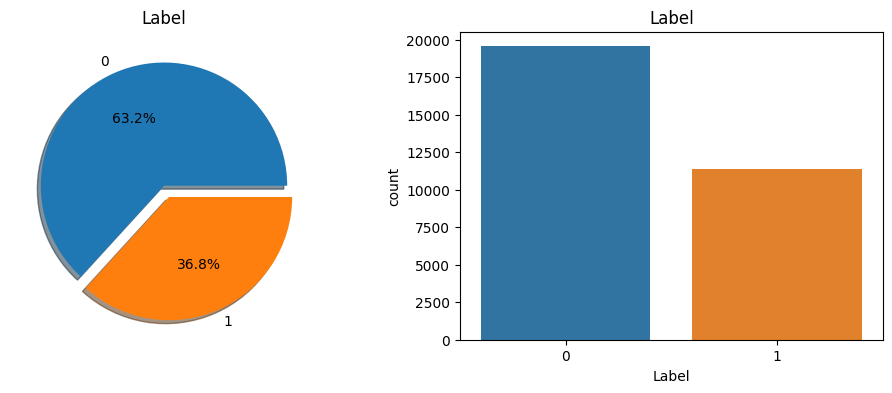

In [18]:
f,ax=plt.subplots(1,2,figsize=(12,4))
df['Label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)


ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(x=df["Label"],ax=ax[1])
ax[1].set_title('Label')
plt.show()

# Approach 1. Count Vectorizer

##  CountVectorizer - Convert a collection of text documents to a matrix of token counts

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
X = df['Sentence']
y = df['Label']
# CountVectorizer - Convert a collection of text documents to a matrix of token counts
count_vectorizer = CountVectorizer(min_df = 2, max_df = 0.8, stop_words = stopwords.words('english'))
X = count_vectorizer.fit_transform(X.values.astype('U')).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
# count_vectorizer.get_feature_names()

### Train-test split 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print("X_train.shape - ",X_train.shape)
print("y_train.shape -", y_train.shape)
print("X_test.shape -", X_test.shape)
print("y_test.shape -", y_test.shape)

X_train.shape -  (24735, 6581)
y_train.shape - (24735,)
X_test.shape - (6184, 6581)
y_test.shape - (6184,)


In [24]:
X_test[0]

array([0, 0, 0, ..., 0, 0, 0])

### Test Validation Split 

In [25]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.4)
print("X_val.shape - ",X_val.shape)
print("y_val.shape -", y_val.shape)
print("X_test.shape -", X_test.shape)
print("y_test.shape -", y_test.shape)

X_val.shape -  (2474, 6581)
y_val.shape - (2474,)
X_test.shape - (3710, 6581)
y_test.shape - (3710,)


## RandomForestClassifier 

In [26]:
# create RandomForestClassifier model instance
rf_clf = RandomForestClassifier()
# fit RandomForestClassifier model
rf_clf.fit(X_train, y_train)
# make predictions
y_pred = rf_clf.predict(X_test)
print(f"Accuracy of Random Forest on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of Random Forest on test set : {f1_score(y_pred, y_test)}")

Accuracy of Random Forest on test set : 0.9274932614555256
F1 Score of Random Forest on test set : 0.8999628114540721


In [27]:
# K Fold cross validation 
# kfold = KFold(n_splits=5, shuffle=True)
# kf_cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=kfold )
# print("K-fold CV average score for RandomForestClassifier: %.2f" % kf_cv_scores.mean())

In [28]:
# K-Fold Cross-Validation
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [10]:
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [11]:
rf_clf_cv_result = cross_validation(rf_clf, X_train, y_train, 5)
print(rf_clf_cv_result)

NameError: name 'cross_validation' is not defined

In [12]:
# Plot Accuracy Result
model_name = "Random Forest CV"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            rf_clf_cv_result["Training Accuracy scores"],
            rf_clf_cv_result["Validation Accuracy scores"])

NameError: name 'rf_clf_cv_result' is not defined

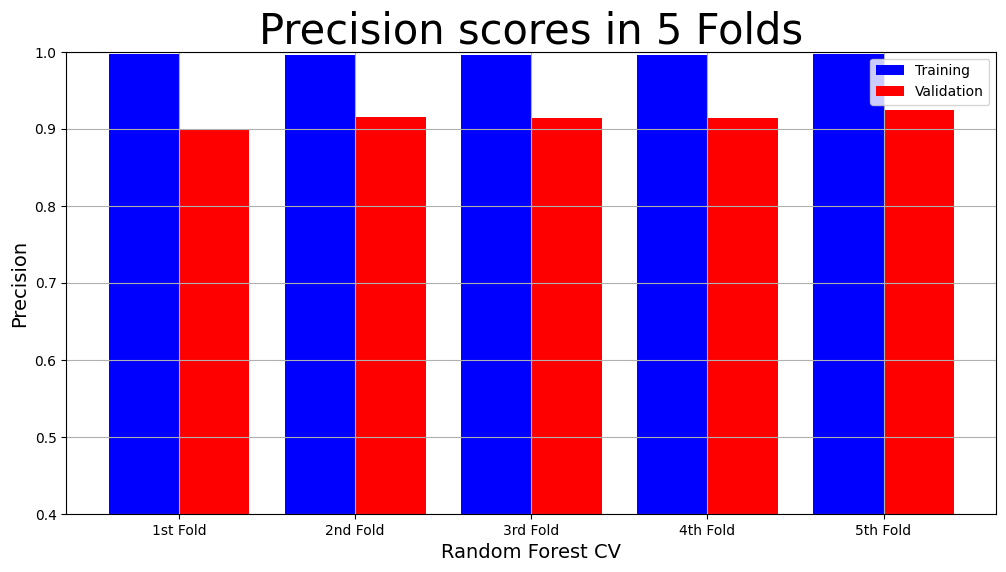

In [32]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            rf_clf_cv_result["Training Precision scores"],
            rf_clf_cv_result["Validation Precision scores"])

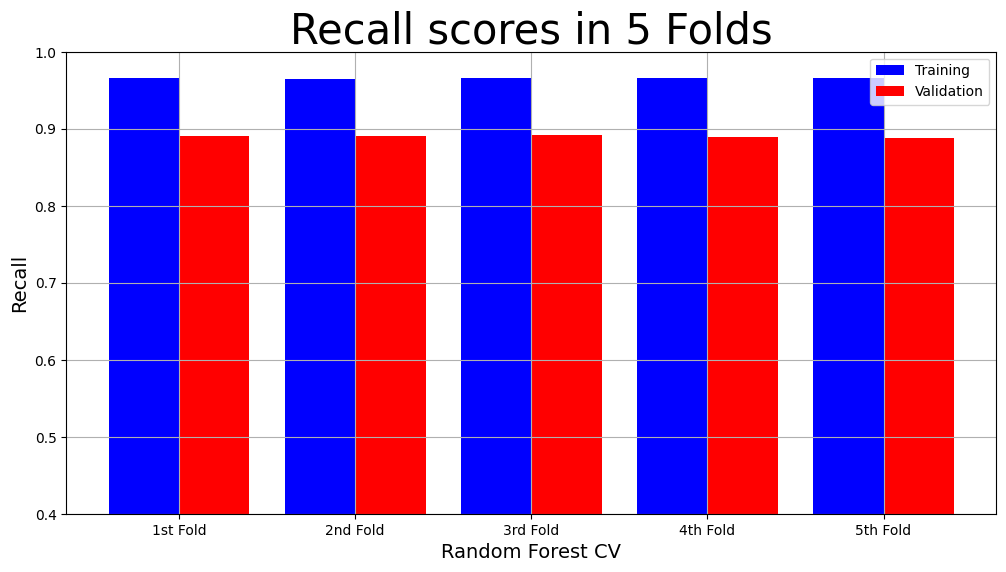

In [33]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            rf_clf_cv_result["Training Recall scores"],
            rf_clf_cv_result["Validation Recall scores"])

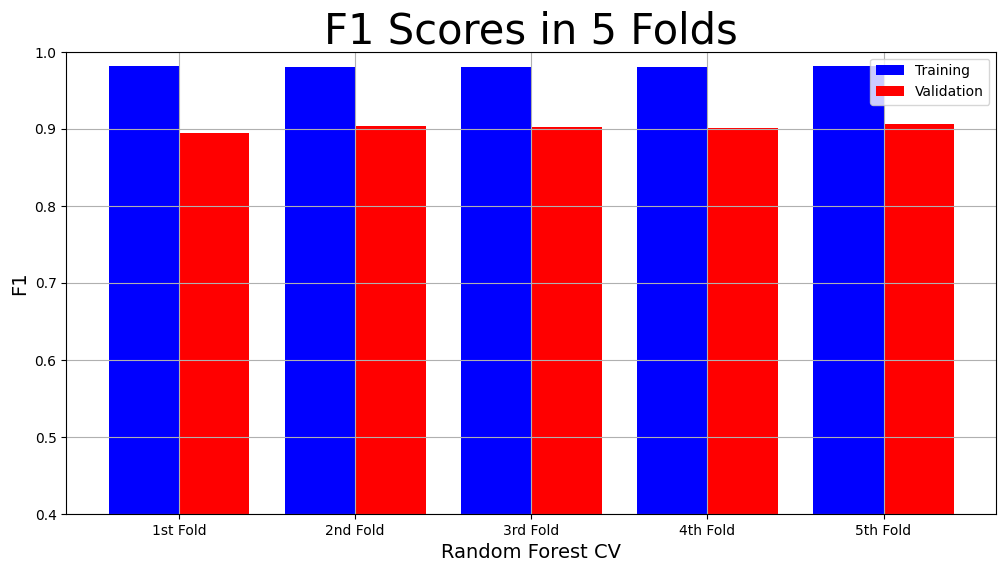

In [34]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            rf_clf_cv_result["Training F1 scores"],
            rf_clf_cv_result["Validation F1 scores"])

In [9]:

# calculate AUC
try:
    auc = roc_auc_score(y_label, probs)
except:
    print('AUC: %.3f' % auc)


NameError: name 'auc' is not defined

In [35]:
import joblib

  
# Save the model as a pickle in a file
joblib.dump(rf_clf, r'/kaggle/working/rf_clf_cv.pkl')

['/kaggle/working/rf_clf_cv.pkl']

In [36]:
import pickle

# save the model to disk
filename = '/kaggle/working/rf_clf_cv.sav'
pickle.dump(rf_clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9274932614555256


### Classification Report of RandomForestClassifier

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2325
           1       0.93      0.87      0.90      1385

    accuracy                           0.93      3710
   macro avg       0.93      0.92      0.92      3710
weighted avg       0.93      0.93      0.93      3710



### Confusion  matrix of RandomForest Classifier

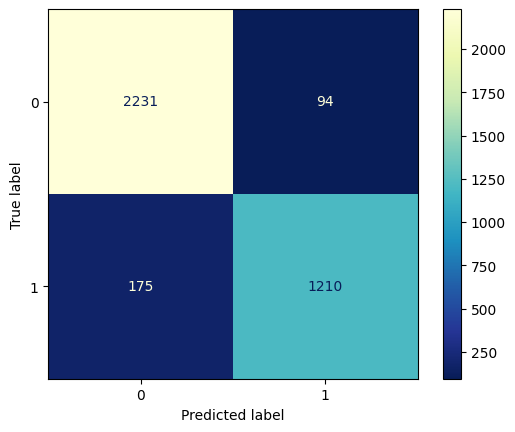

In [38]:
confmatrix = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

In [39]:
print("Confusion Matrix of our RandomForest Classifier", confmatrix)

TP = confmatrix[1,1] # true positive
TN = confmatrix[0,0] # true negatives
FP = confmatrix[0,1] # false positives
FN = confmatrix[1,0] # false negatives

# Let's see the sensitivity of our RandomForest Classifier
sensitivity = TP / float(TP+FN)
print("sensitivity of our RandomForest Classifier ", sensitivity)

# Let us calculate specificity of our RandomForest Classifier
specificity = TN / float(TN+FP)
print("specificity of our RandomForest Classifier ", specificity)

Confusion Matrix of our RandomForest Classifier [[2231   94]
 [ 175 1210]]
sensitivity of our RandomForest Classifier  0.8736462093862816
specificity of our RandomForest Classifier  0.9595698924731183


## XGBoost Classifier 

In [40]:
# create XGBoost model instance
xgb_clf = XGBClassifier(learning_rate=0.01, alpha = 10,objective='binary:logistic')
# fit XGBoost model
xgb_clf.fit(X, y)
# make predictions
y_pred = xgb_clf.predict(X_test)
print(f"Accuracy of XGBClassifier on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of XGBClassifier on test set : {f1_score(y_pred, y_test)}")

Accuracy of XGBClassifier on test set : 0.8692722371967655
F1 Score of XGBClassifier on test set : 0.7947524333474398


In [41]:
# K Fold cross validation 
# kfold = KFold(n_splits=5, shuffle=True)
# kf_cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=kfold )
# print("K-fold CV average score for RandomForestClassifier: %.2f" % kf_cv_scores.mean())

In [42]:
# K-Fold Cross-Validation
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [43]:
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [44]:
xgb_clf_cv_result = cross_validation(xgb_clf, X_train, y_train, 5)
print(xgb_clf_cv_result)

{'Training Accuracy scores': array([0.86249242, 0.86633313, 0.86097635, 0.86218921, 0.86749545]), 'Mean Training Accuracy': 86.38973115019205, 'Training Precision scores': array([0.95174477, 0.95069458, 0.95163556, 0.94899782, 0.94777563]), 'Mean Training Precision': 0.9501696705161639, 'Training Recall scores': array([0.65816327, 0.67002206, 0.65388858, 0.6594043 , 0.67567568]), 'Mean Training Recall': 0.6634307777164921, 'Training F1 scores': array([0.77818538, 0.78605516, 0.77515325, 0.77813034, 0.78892288]), 'Mean Training F1 Score': 0.7812894013827532, 'Validation Accuracy scores': array([0.85688296, 0.86982009, 0.85809582, 0.8585001 , 0.86739438]), 'Mean Validation Accuracy': 86.21386699009503, 'Validation Precision scores': array([0.93675889, 0.9485802 , 0.9447558 , 0.94915254, 0.95876289]), 'Mean Validation Precision': 0.9476020652869381, 'Validation Recall scores': array([0.6536128 , 0.68174297, 0.65085494, 0.64864865, 0.66685052]), 'Mean Validation Recall': 0.660341974627689,

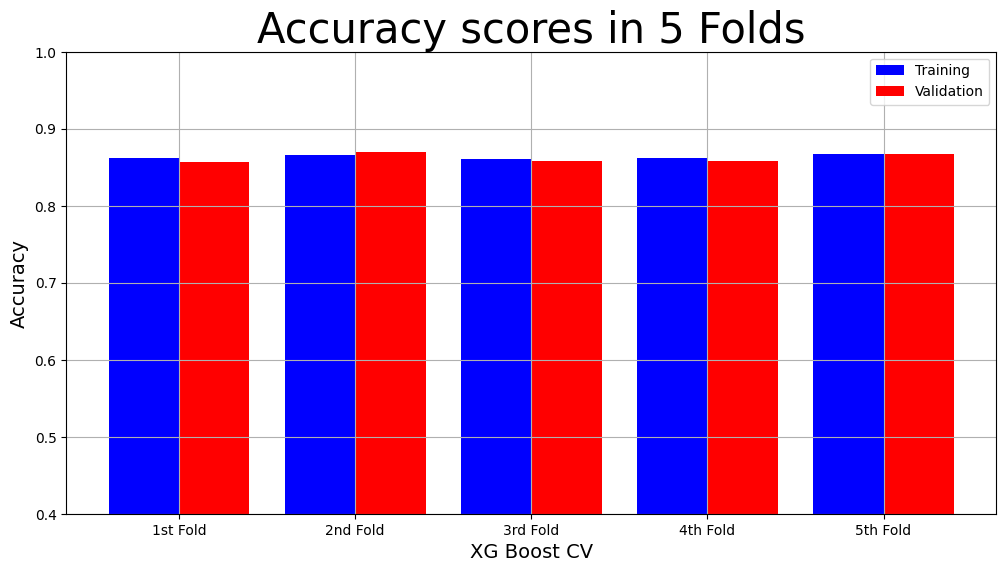

In [45]:
# Plot Accuracy Result
model_name = "XG Boost CV"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            xgb_clf_cv_result["Training Accuracy scores"],
            xgb_clf_cv_result["Validation Accuracy scores"])

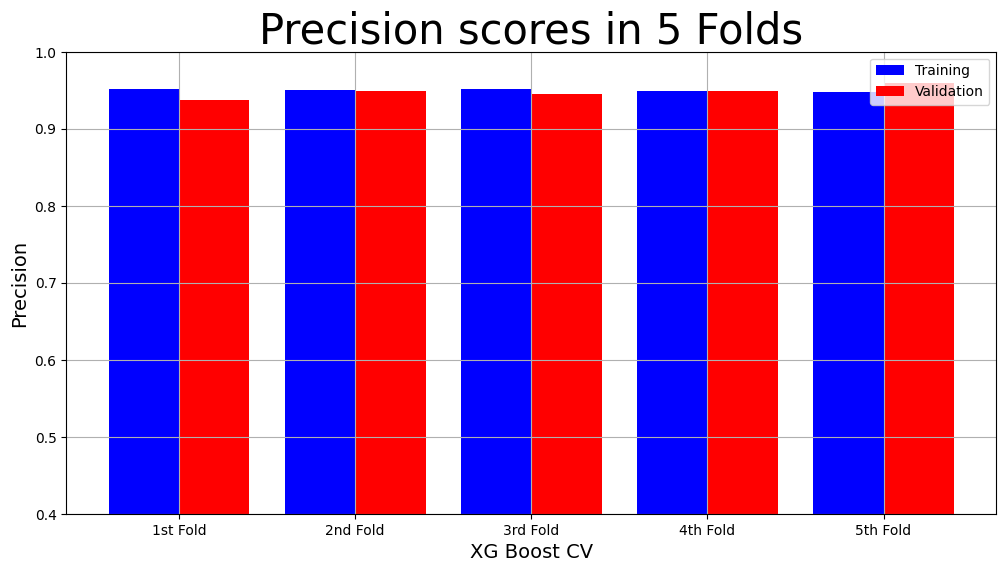

In [46]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            xgb_clf_cv_result["Training Precision scores"],
            xgb_clf_cv_result["Validation Precision scores"])

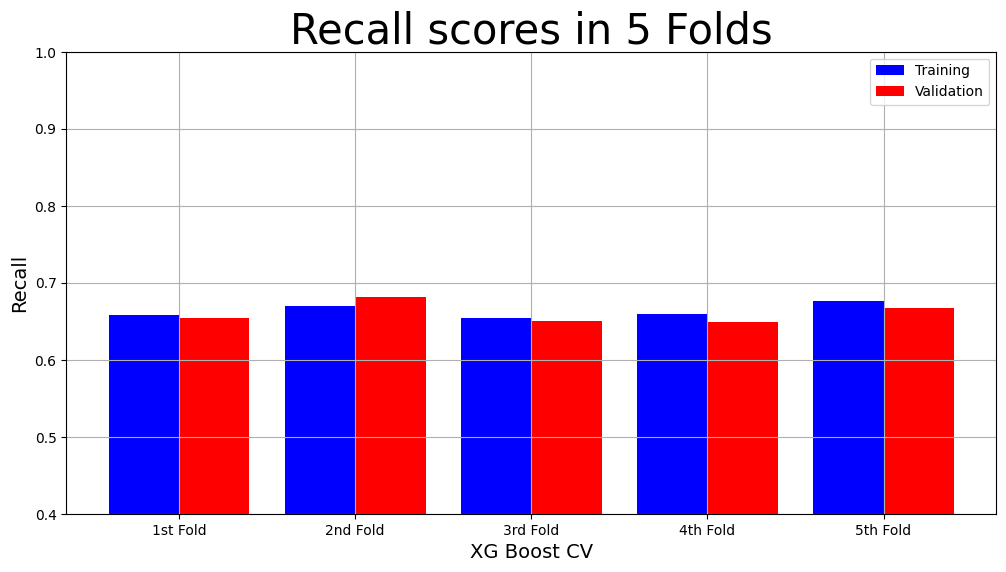

In [47]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            xgb_clf_cv_result["Training Recall scores"],
            xgb_clf_cv_result["Validation Recall scores"])

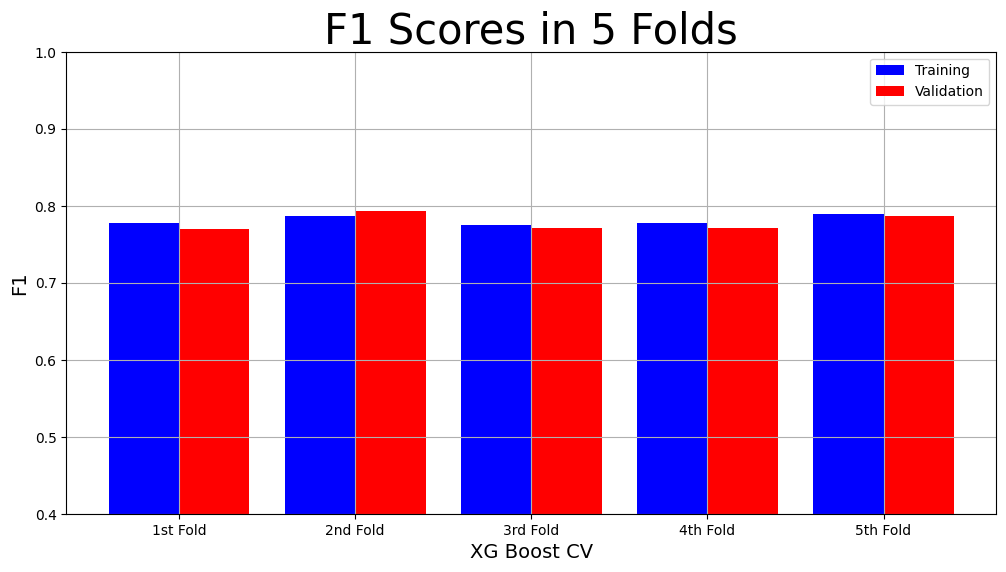

In [48]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            xgb_clf_cv_result["Training F1 scores"],
            xgb_clf_cv_result["Validation F1 scores"])

In [49]:
import joblib
  
  
# Save the model as a pickle in a file
joblib.dump(xgb_clf, r'/kaggle/working/xgb_clf_cv.pkl')

['/kaggle/working/xgb_clf_cv.pkl']

In [50]:
import pickle

# save the model to disk
filename = '/kaggle/working/xgb_clf_cv.sav'
pickle.dump(xgb_clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8692722371967655


### Classification Report of XGBoost Classifier

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      2325
           1       0.96      0.68      0.79      1385

    accuracy                           0.87      3710
   macro avg       0.90      0.83      0.85      3710
weighted avg       0.88      0.87      0.86      3710



### Confusion Matrix of XGBoost Classifier

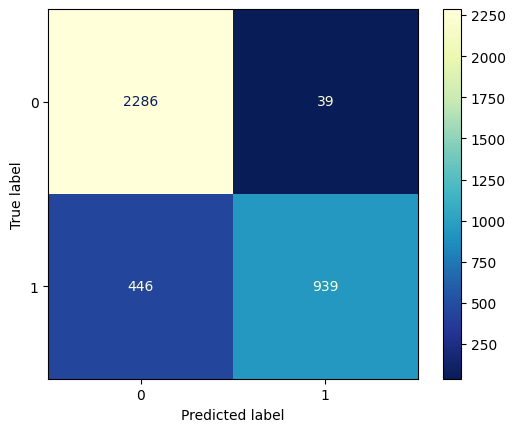

In [52]:
confmatrix = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

In [53]:
print("Confusion Matrix of our XGBoost Classifier", confmatrix)

TP = confmatrix[1,1] # true positive
TN = confmatrix[0,0] # true negatives
FP = confmatrix[0,1] # false positives
FN = confmatrix[1,0] # false negatives

# Let's see the sensitivity of our XGBoost Classifier
sensitivity = TP / float(TP+FN)
print("sensitivity of our XGBoost Classifier", sensitivity)

# Let us calculate specificity of our XGBoost Classifier
specificity = TN / float(TN+FP)
print("specificity of our XGBoost Classifier", specificity)

Confusion Matrix of our XGBoost Classifier [[2286   39]
 [ 446  939]]
sensitivity of our XGBoost Classifier 0.6779783393501805
specificity of our XGBoost Classifier 0.983225806451613


## ExtraTreesClassifier 

In [54]:
# create ExtraTreesClassifier model instance
xtree_clf = ExtraTreesClassifier(random_state=0)
# fit ExtraTreesClassifier model
xtree_clf.fit(X, y)
# make predictions
y_pred = xtree_clf.predict(X_test)
print(f"Accuracy of ExtraTreesClassifier on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of ExtraTreesClassifier on test set : {f1_score(y_pred, y_test)}")

Accuracy of ExtraTreesClassifier on test set : 0.982210242587601
F1 Score of ExtraTreesClassifier on test set : 0.975735294117647


In [55]:
# K Fold cross validation 
# kfold = KFold(n_splits=5, shuffle=True)
# kf_cv_scores = cross_val_score(xtree_clf, X, y, cv=kfold )
# print("K-fold CV average score for ExtraTreesClassifier: %.2f" % kf_cv_scores.mean())

In [56]:
# K-Fold Cross-Validation
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [57]:
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [58]:
xtree_clf_cv_result = cross_validation(xtree_clf, X_train, y_train, 5)
print(xtree_clf_cv_result)

{'Training Accuracy scores': array([0.9864059 , 0.98579947, 0.98585001, 0.98615322, 0.98650697]), 'Mean Training Accuracy': 98.61431170406307, 'Training Precision scores': array([0.99644533, 0.99629788, 0.99587482, 0.99601933, 0.99687011]), 'Mean Training Precision': 0.9963014947918125, 'Training Recall scores': array([0.96635411, 0.96483729, 0.96538886, 0.96607832, 0.96621622]), 'Mean Training Recall': 0.9657749586321016, 'Training F1 scores': array([0.98116906, 0.98031524, 0.9803949 , 0.98082038, 0.98130383]), 'Mean Training F1 Score': 0.9808006822822508, 'Validation Accuracy scores': array([0.92722862, 0.93491005, 0.93066505, 0.93066505, 0.93389933]), 'Mean Validation Accuracy': 93.14736203759854, 'Validation Precision scores': array([0.90204759, 0.92527096, 0.91199552, 0.91478555, 0.92408676]), 'Mean Validation Precision': 0.9156372766980045, 'Validation Recall scores': array([0.89906233, 0.89464975, 0.89740761, 0.89409818, 0.89299504]), 'Mean Validation Recall': 0.8956425813568671

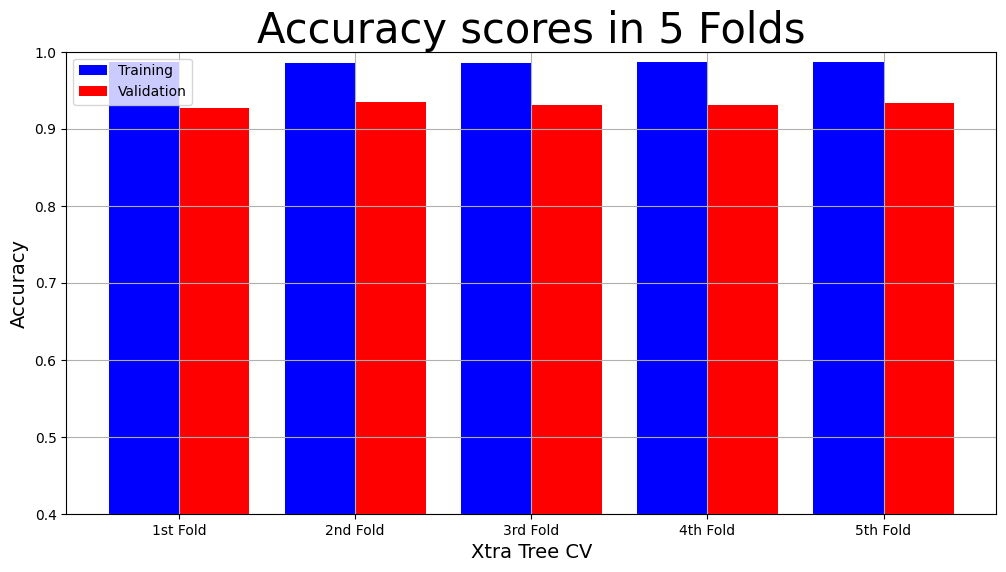

In [59]:
# Plot Accuracy Result
model_name = "Xtra Tree CV"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            xtree_clf_cv_result["Training Accuracy scores"],
            xtree_clf_cv_result["Validation Accuracy scores"])

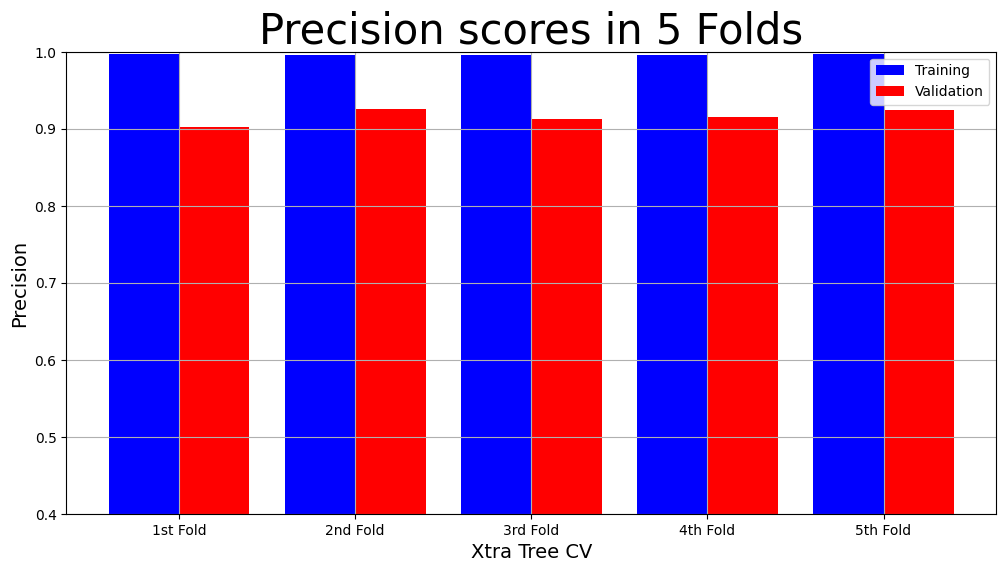

In [60]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            xtree_clf_cv_result["Training Precision scores"],
            xtree_clf_cv_result["Validation Precision scores"])

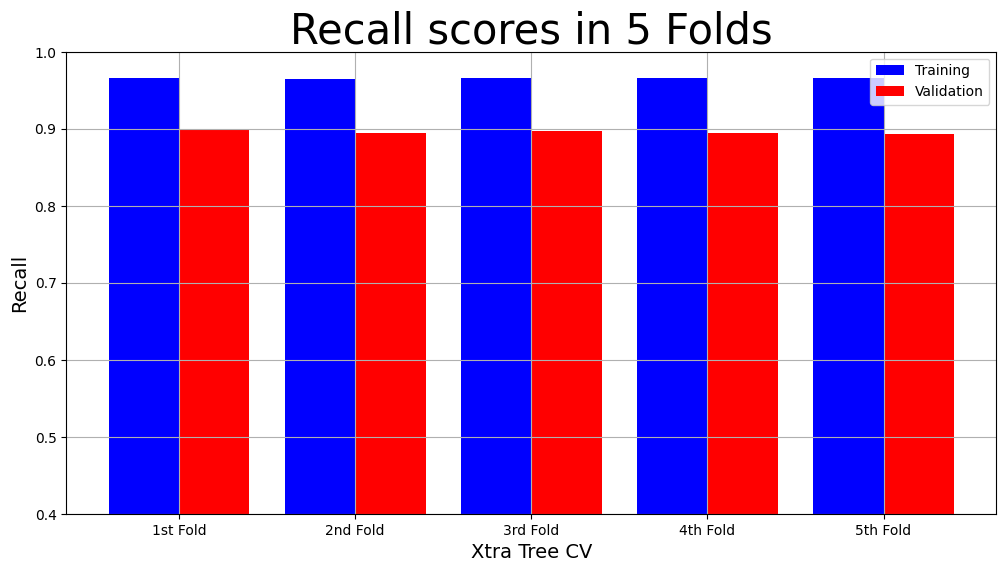

In [61]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            xtree_clf_cv_result["Training Recall scores"],
            xtree_clf_cv_result["Validation Recall scores"])

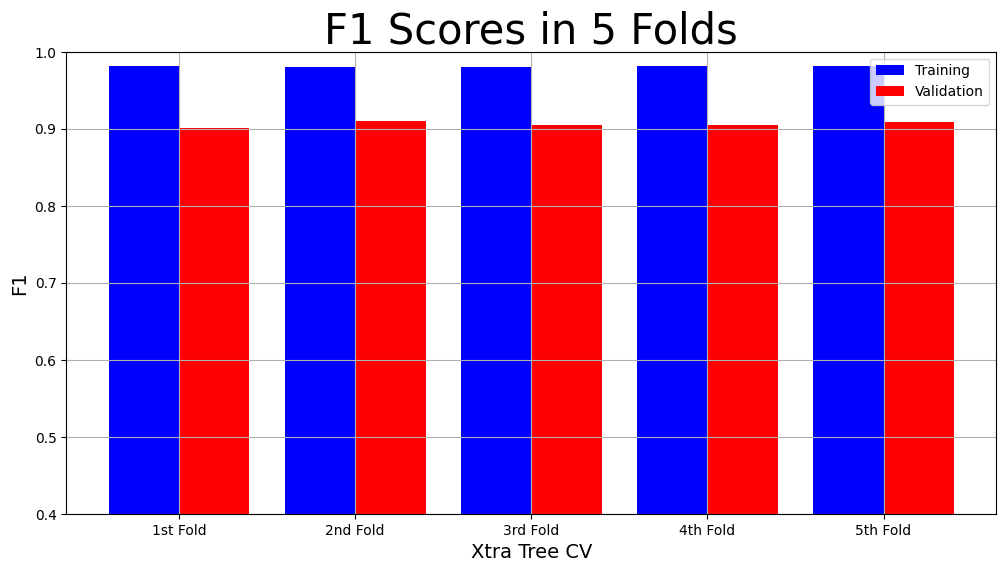

In [62]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            xtree_clf_cv_result["Training F1 scores"],
            xtree_clf_cv_result["Validation F1 scores"])

In [63]:
import joblib
  
  
# Save the model as a pickle in a file
joblib.dump(xtree_clf, r'/kaggle/working/xtree_clf_cv.pkl')

['/kaggle/working/xtree_clf_cv.pkl']

In [64]:
import pickle

# save the model to disk
filename = '/kaggle/working/xtree_clf_cv.sav'
pickle.dump(xtree_clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.982210242587601


### Classification Report of ExtraTreesClassifier

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2325
           1       0.99      0.96      0.98      1385

    accuracy                           0.98      3710
   macro avg       0.98      0.98      0.98      3710
weighted avg       0.98      0.98      0.98      3710



### Confusion Matrix of ExtraTreesClassifier

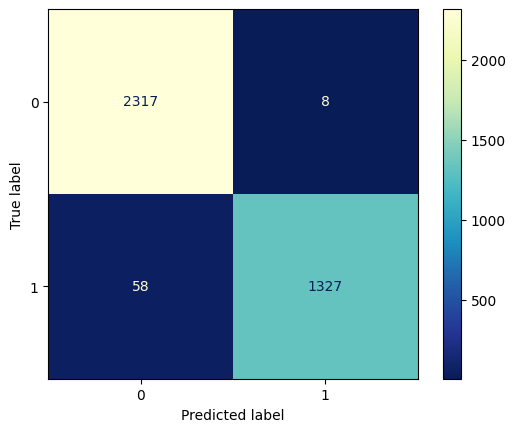

In [66]:
confmatrix = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

In [67]:
print("Confusion Matrix of our ExtraTreesClassifier", confmatrix)

TP = confmatrix[1,1] # true positive
TN = confmatrix[0,0] # true negatives
FP = confmatrix[0,1] # false positives
FN = confmatrix[1,0] # false negatives

# Let's see the sensitivity of our ExtraTreesClassifier
sensitivity = TP / float(TP+FN)
print("sensitivity of our ExtraTreesClassifier", sensitivity)

# Let us calculate specificity of our ExtraTreesClassifier
specificity = TN / float(TN+FP)
print("specificity of our ExtraTreesClassifier", specificity)

Confusion Matrix of our ExtraTreesClassifier [[2317    8]
 [  58 1327]]
sensitivity of our ExtraTreesClassifier 0.9581227436823104
specificity of our ExtraTreesClassifier 0.9965591397849463


## TfidfVectorizer - Convert a collection of raw documents to a matrix of TF-IDF features. 

In [22]:
# TfidfVectorizer - Convert a collection of raw documents to a matrix of TF-IDF features.# 

X = df['Sentence']
y = df['Label']

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X.values.astype('U')).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
# feature names
# tfidf_vectorizer.get_feature_names()

### Train Test Split 

In [24]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size = 0.2)
print("X_train_tfidf.shape=", X_train_tfidf.shape)
print("y_train_tfidf.shape=", y_train_tfidf.shape)
print("X_test_tfidf.shape=", X_test_tfidf.shape)
print("y_test_tfidf.shape=", y_test_tfidf.shape)

X_train_tfidf.shape= (24735, 24747)
y_train_tfidf.shape= (24735,)
X_test_tfidf.shape= (6184, 24747)
y_test_tfidf.shape= (6184,)


Test Validation Split

In [25]:
X_test_tfidf, X_val_tfidf, y_test_tfidf, y_val_tfidf = train_test_split(X_test_tfidf, y_test_tfidf, test_size = 0.4)
print("X_val.shape - ",X_val_tfidf.shape)
print("y_val.shape -", y_val_tfidf.shape)
print("X_test.shape -", X_test_tfidf.shape)
print("y_test.shape -", y_test_tfidf.shape)

X_val.shape -  (2474, 24747)
y_val.shape - (2474,)
X_test.shape - (3710, 24747)
y_test.shape - (3710,)


##  Random Forest Classifier

In [22]:
# create RandomForestClassifier model instance
rf_clf_tfidf = RandomForestClassifier()
# fit RandomForestClassifier model
rf_clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
# make predictions
y_pred_tfidf = rf_clf_tfidf.predict(X_test_tfidf)
print(f"Accuracy of Random Forest on test set : {accuracy_score(y_pred_tfidf, y_test_tfidf)}")
print(f"F1 Score of Random Forest on test set : {f1_score(y_pred_tfidf, y_test_tfidf)}")

KeyboardInterrupt: 

In [73]:
# K Fold cross validation 
# kfold = KFold(n_splits=5, shuffle=True)
# kf_cv_scores = cross_val_score(rf_clf_tfidf, X_train_tfidf, y_train_tfidf, cv=kfold )
# print("K-fold CV average score for Random Forest Classifier: %.2f" % kf_cv_scores.mean())

In [74]:
# K-Fold Cross-Validation
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [75]:
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [76]:
rf_clf_tfidf_result = cross_validation(rf_clf_tfidf, X_train_tfidf, y_train_tfidf, 5)
print(rf_clf_tfidf_result)

{'Training Accuracy scores': array([0.99959571, 0.99959571, 0.99964625, 0.99964625, 0.99974732]), 'Mean Training Accuracy': 99.96462502526784, 'Training Precision scores': array([0.99917639, 0.99917639, 0.99931356, 0.9991765 , 0.99972524]), 'Mean Training Precision': 0.9993136167050926, 'Training Recall scores': array([0.99972531, 0.99972531, 0.99972531, 0.99986266, 0.99958791]), 'Mean Training Recall': 0.9997253011375384, 'Training F1 scores': array([0.99945078, 0.99945078, 0.9995194 , 0.99951946, 0.99965657]), 'Mean Training F1 Score': 0.999519395797374, 'Validation Accuracy scores': array([0.77845159, 0.7822923 , 0.79179301, 0.78107944, 0.793208  ]), 'Mean Validation Accuracy': 78.53648675965232, 'Validation Precision scores': array([0.62422787, 0.62859121, 0.63898663, 0.62720055, 0.64059197]), 'Mean Validation Precision': 0.631919644222144, 'Validation Recall scores': array([0.99945055, 0.9978022 , 0.9978022 , 0.99835165, 0.99835255]), 'Mean Validation Recall': 0.9983518293897207, 

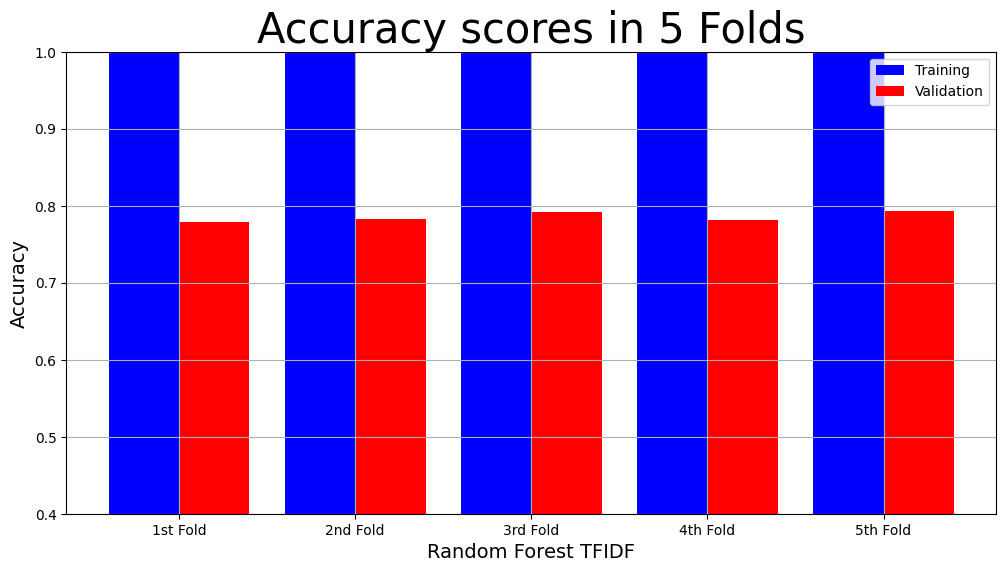

In [77]:
# Plot Accuracy Result
model_name = "Random Forest TFIDF"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            rf_clf_tfidf_result["Training Accuracy scores"],
            rf_clf_tfidf_result["Validation Accuracy scores"])

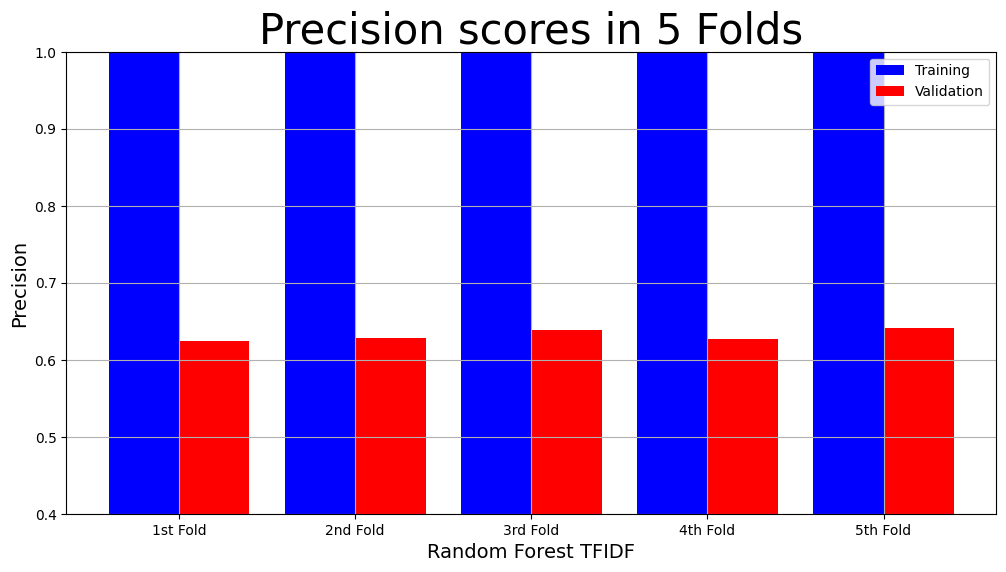

In [78]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            rf_clf_tfidf_result["Training Precision scores"],
            rf_clf_tfidf_result["Validation Precision scores"])

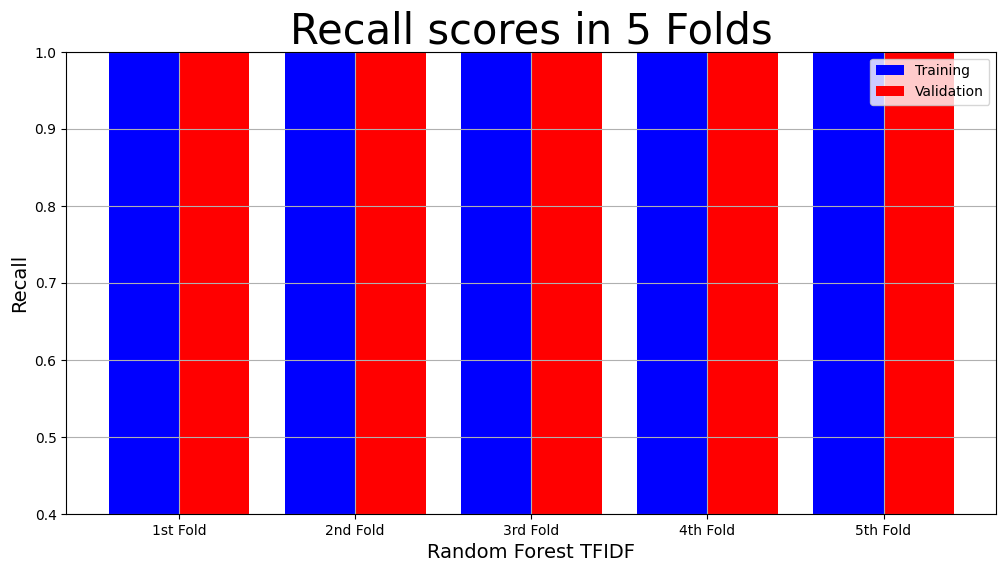

In [79]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            rf_clf_tfidf_result["Training Recall scores"],
            rf_clf_tfidf_result["Validation Recall scores"])

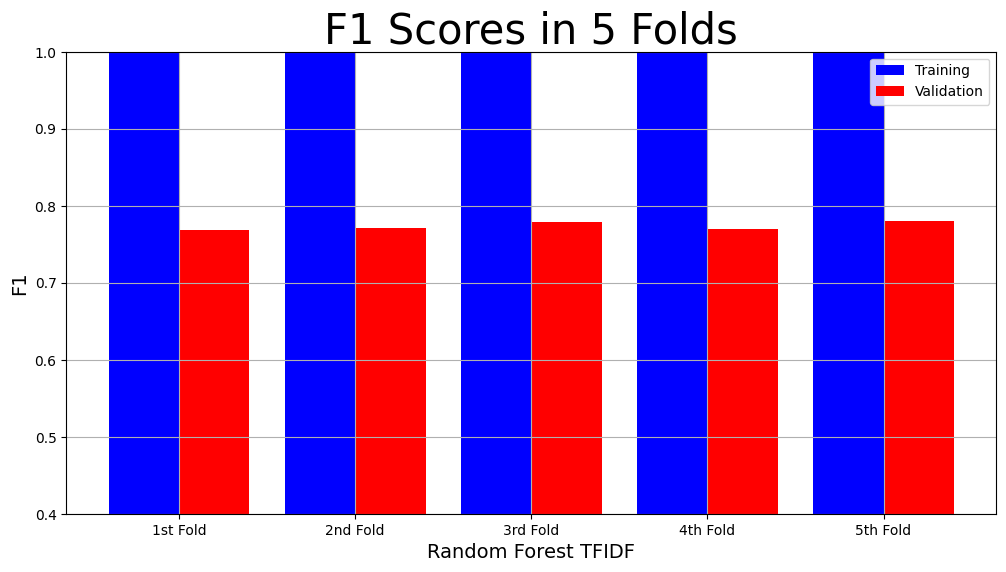

In [80]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            rf_clf_tfidf_result["Training F1 scores"],
            rf_clf_tfidf_result["Validation F1 scores"])

### Classification Report 

In [81]:
print(classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       1.00      0.66      0.80      2339
           1       0.63      1.00      0.78      1371

    accuracy                           0.79      3710
   macro avg       0.82      0.83      0.79      3710
weighted avg       0.86      0.79      0.79      3710



### Confusion Matrix 

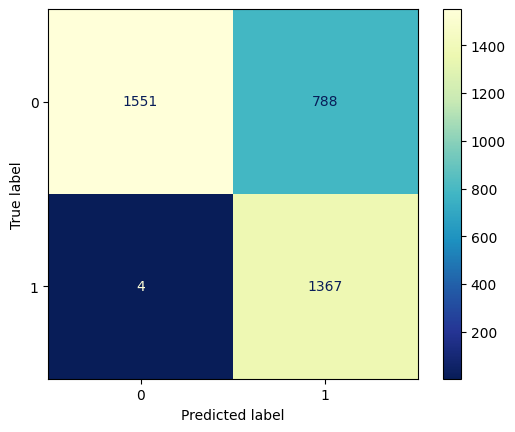

In [82]:
confmatrix = confusion_matrix(y_test_tfidf, y_pred_tfidf)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

In [83]:
print("Confusion Matrix of our RandomForest Classifier", confmatrix)

TP = confmatrix[1,1] # true positive
TN = confmatrix[0,0] # true negatives
FP = confmatrix[0,1] # false positives
FN = confmatrix[1,0] # false negatives

# Let's see the sensitivity of our RandomForest Classifier
sensitivity = TP / float(TP+FN)
print("sensitivity of our RandomForest Classifier ", sensitivity)

# Let us calculate specificity of our RandomForest Classifier
specificity = TN / float(TN+FP)
print("specificity of our RandomForest Classifier ", specificity)

Confusion Matrix of our RandomForest Classifier [[1551  788]
 [   4 1367]]
sensitivity of our RandomForest Classifier  0.9970824215900802
specificity of our RandomForest Classifier  0.6631038905515177


In [84]:
import joblib
  
  
# Save the xgb_clf_tfidf model as a pickle in a file
joblib.dump(rf_clf_tfidf, r'/kaggle/working/rf_clf_tfidf.pkl')

['/kaggle/working/rf_clf_tfidf.pkl']

In [85]:
import pickle

# save the model to disk
filename = '/kaggle/working/rf_clf_tfidf.sav'
pickle.dump(rf_clf_tfidf, open(filename, 'wb'))

In [86]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_tfidf, y_test_tfidf)
print(result)

0.786522911051213


## XGBoost Classifier 

In [26]:
# create XGBoost model instance
xgb_clf_tfidf = XGBClassifier(learning_rate=0.01,objective='binary:logistic')
# fit XGBoost model
xgb_clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
# make predictions
y_pred_tfidf = xgb_clf_tfidf.predict(X_test_tfidf)
print(f"Accuracy of XGBClassifier on test set : {accuracy_score(y_pred_tfidf, y_test_tfidf)}")
print(f"F1 Score of XGBClassifier on test set : {f1_score(y_pred_tfidf, y_test_tfidf)}")

Accuracy of XGBClassifier on test set : 0.9838274932614556
F1 Score of XGBClassifier on test set : 0.9771341463414634


In [27]:
# K Fold cross validation 
# kfold = KFold(n_splits=5, shuffle=True)
# kf_cv_scores = cross_val_score(xgb_clf_tfidf, X_train_tfidf, y_train_tfidf, cv=kfold )
# print("K-fold CV average score for XGBoost Classifier: %.2f" % kf_cv_scores.mean())

In [28]:
# K-Fold Cross-Validation
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [29]:
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [30]:
xgb_clf_tfidf_result = cross_validation(xgb_clf_tfidf, X_train_tfidf, y_train_tfidf, 5)
print(xgb_clf_tfidf_result)

{'Training Accuracy scores': array([0.98099859, 0.98125126, 0.98089751, 0.98175662, 0.97680412]), 'Mean Training Accuracy': 98.03416211845561, 'Training Precision scores': array([0.99613402, 0.99613679, 0.99556509, 0.99670959, 0.99738448]), 'Mean Training Precision': 0.9963859932728377, 'Training Recall scores': array([0.95223104, 0.95291541, 0.95250479, 0.95373032, 0.93963039]), 'Mean Training Recall': 0.9502023914785612, 'Training F1 scores': array([0.97368789, 0.97404687, 0.97355904, 0.97474641, 0.96764644]), 'Mean Training F1 Score': 0.9727373304737821, 'Validation Accuracy scores': array([0.97958359, 0.97998787, 0.9805943 , 0.97877502, 0.97756216]), 'Mean Validation Accuracy': 97.93005862138668, 'Validation Precision scores': array([0.9959747 , 0.99484241, 0.99655568, 0.99596774, 0.99197248]), 'Mean Validation Precision': 0.9950626014203401, 'Validation Recall scores': array([0.94852136, 0.95071194, 0.95071194, 0.94636015, 0.9469075 ]), 'Mean Validation Recall': 0.9486425774751492

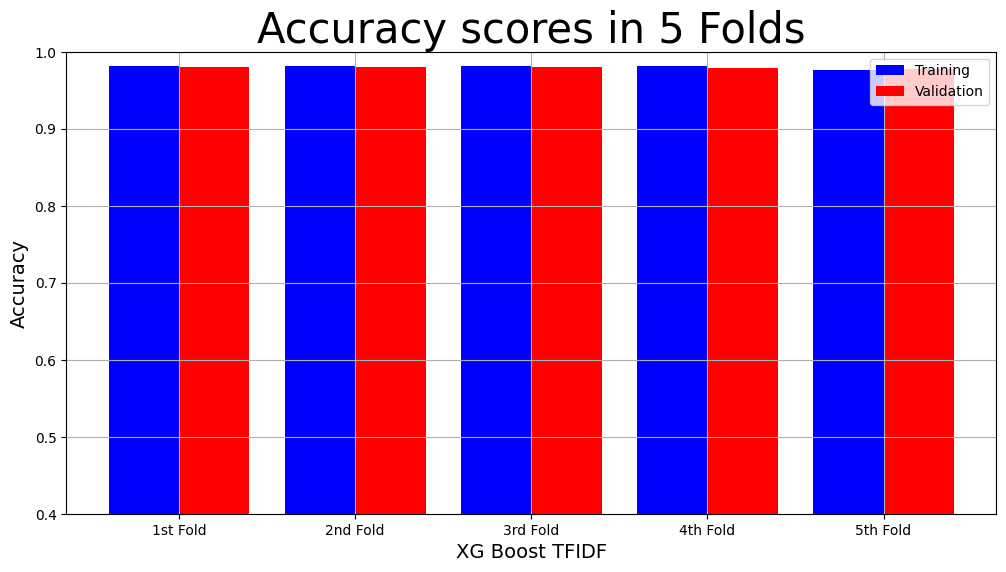

In [31]:
# Plot Accuracy Result
model_name = "XG Boost TFIDF"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            xgb_clf_tfidf_result["Training Accuracy scores"],
            xgb_clf_tfidf_result["Validation Accuracy scores"])

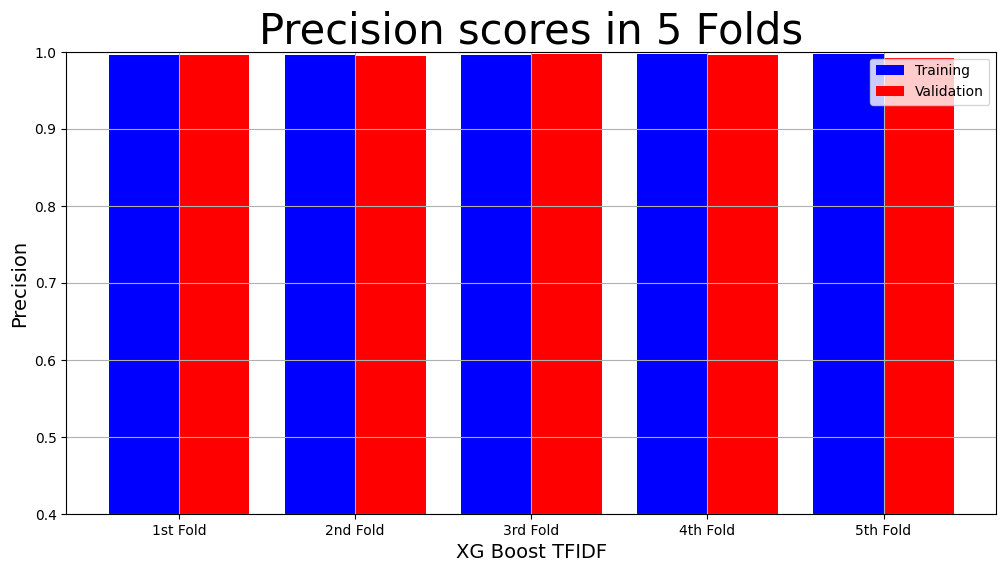

In [32]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            xgb_clf_tfidf_result["Training Precision scores"],
            xgb_clf_tfidf_result["Validation Precision scores"])

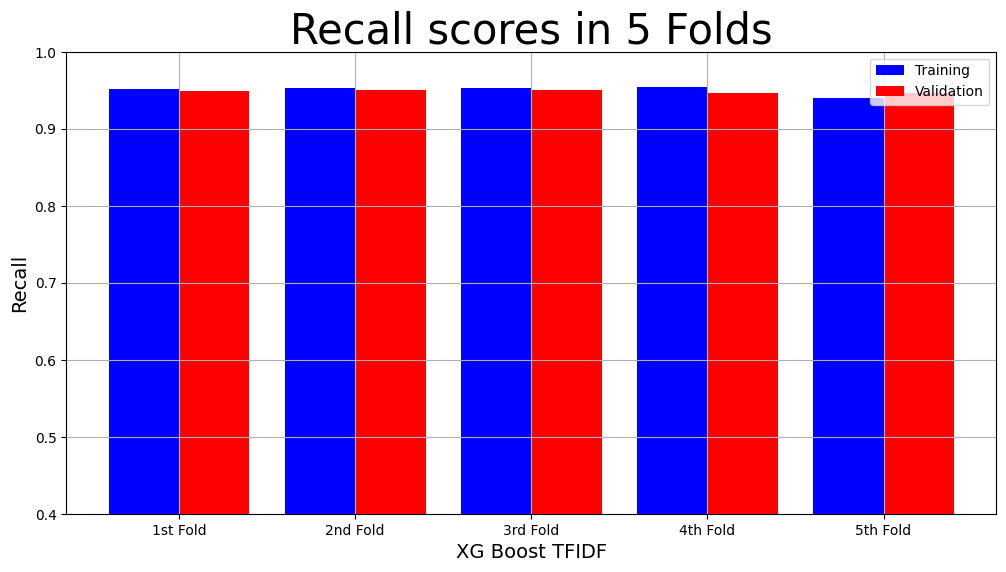

In [33]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            xgb_clf_tfidf_result["Training Recall scores"],
            xgb_clf_tfidf_result["Validation Recall scores"])

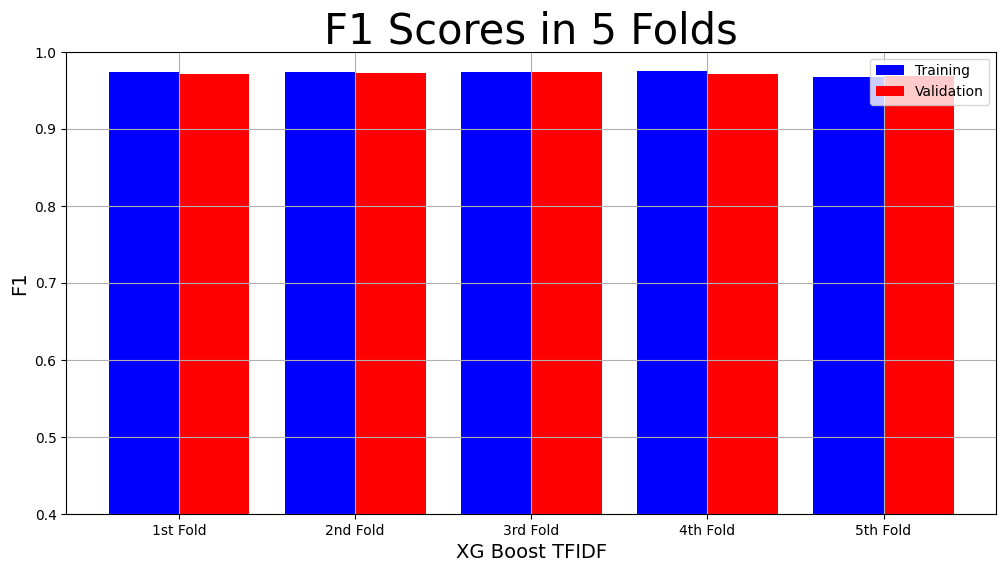

In [34]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            xgb_clf_tfidf_result["Training F1 scores"],
            xgb_clf_tfidf_result["Validation F1 scores"])

### Classification Report 

In [35]:
print(classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2377
           1       0.99      0.96      0.98      1333

    accuracy                           0.98      3710
   macro avg       0.99      0.98      0.98      3710
weighted avg       0.98      0.98      0.98      3710



### Confusion Matrix 

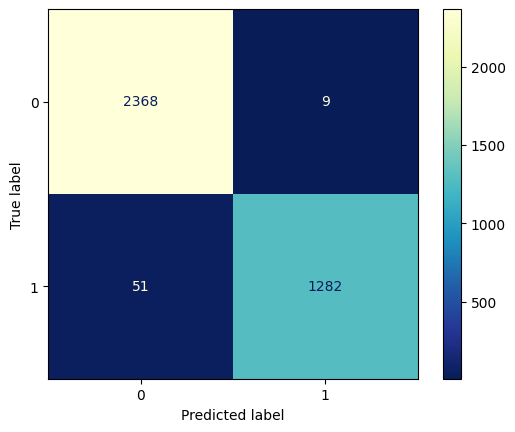

In [36]:
confmatrix = confusion_matrix(y_test_tfidf, y_pred_tfidf)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

In [37]:
print("Confusion Matrix of our XGBoost Classifier", confmatrix)

TP = confmatrix[1,1] # true positive
TN = confmatrix[0,0] # true negatives
FP = confmatrix[0,1] # false positives
FN = confmatrix[1,0] # false negatives

# Let's see the sensitivity of our XGBoost Classifier
sensitivity = TP / float(TP+FN)
print("sensitivity of our XGBoost Classifier", sensitivity)

# Let us calculate specificity of our XGBoost Classifier
specificity = TN / float(TN+FP)
print("specificity of our XGBoost Classifier", specificity)

Confusion Matrix of our XGBoost Classifier [[2368    9]
 [  51 1282]]
sensitivity of our XGBoost Classifier 0.9617404351087772
specificity of our XGBoost Classifier 0.9962137147665124


In [38]:
import joblib
  
  
# Save the xgb_clf_tfidf model as a pickle in a file
joblib.dump(xgb_clf_tfidf, r'/kaggle/working/xgb_clf_tfidf.pkl')

['/kaggle/working/xgb_clf_tfidf.pkl']

In [39]:
import pickle

# save the model to disk
filename = '/kaggle/working/xgb_clf_tfidf.sav'
pickle.dump(xgb_clf_tfidf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_tfidf, y_test_tfidf)
print(result)

0.9838274932614556


## Extratree Classifier 

In [40]:
# create ExtraTreesClassifier model instance
xtree_clf_tfidf = ExtraTreesClassifier(random_state=0)
# fit ExtraTreesClassifier model
xtree_clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
# make predictions
y_pred_tfidf = xtree_clf_tfidf.predict(X_test_tfidf)
print(f"Accuracy of ExtraTreesClassifier on test set : {accuracy_score(y_pred_tfidf, y_test_tfidf)}")
print(f"F1 Score of ExtraTreesClassifier on test set : {f1_score(y_pred_tfidf, y_test_tfidf)}")

Accuracy of ExtraTreesClassifier on test set : 0.7951482479784366
F1 Score of ExtraTreesClassifier on test set : 0.7776477472205968


In [41]:
# K Fold cross validation 
# kfold = KFold(n_splits=5, shuffle=True)
# kf_cv_scores = cross_val_score(xtree_clf_tfidf, X_train_tfidf, y_train_tfidf, cv=kfold )
# print("K-fold CV average score for Extratree Classifier: %.2f" % kf_cv_scores.mean())

In [42]:
# K-Fold Cross-Validation
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [43]:
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [44]:
xtree_clf_tfidf_result = cross_validation(xtree_clf_tfidf, X_train_tfidf, y_train_tfidf, 5)
print(xtree_clf_tfidf_result)

{'Training Accuracy scores': array([0.99984839, 0.99979786, 0.99984839, 0.99979786, 0.99989893]), 'Mean Training Accuracy': 99.98382858297958, 'Training Precision scores': array([1.        , 0.99986309, 0.99972629, 0.99972621, 0.99986311]), 'Mean Training Precision': 0.9998357401918959, 'Training Recall scores': array([0.99958938, 0.99958938, 0.99986313, 0.99972621, 0.99986311]), 'Mean Training Recall': 0.9997262411530901, 'Training F1 scores': array([0.99979465, 0.99972621, 0.9997947 , 0.99972621, 0.99986311]), 'Mean Training F1 Score': 0.9997809775569759, 'Validation Accuracy scores': array([0.79179301, 0.79987871, 0.79522943, 0.79058015, 0.79239943]), 'Mean Validation Accuracy': 79.39761471598949, 'Validation Precision scores': array([0.6398454 , 0.64864865, 0.64369035, 0.63833508, 0.64035088]), 'Mean Validation Precision': 0.642174071006734, 'Validation Recall scores': array([0.99726177, 0.99890471, 0.99726177, 0.99890531, 0.99890531]), 'Mean Validation Recall': 0.9982477753977547,

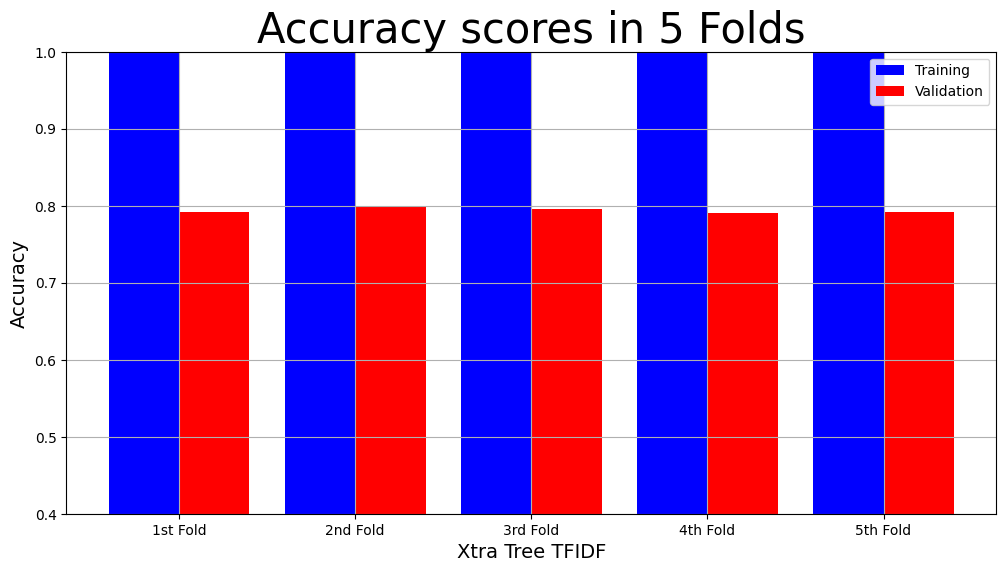

In [45]:
# Plot Accuracy Result
model_name = "Xtra Tree TFIDF"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            xtree_clf_tfidf_result["Training Accuracy scores"],
            xtree_clf_tfidf_result["Validation Accuracy scores"])

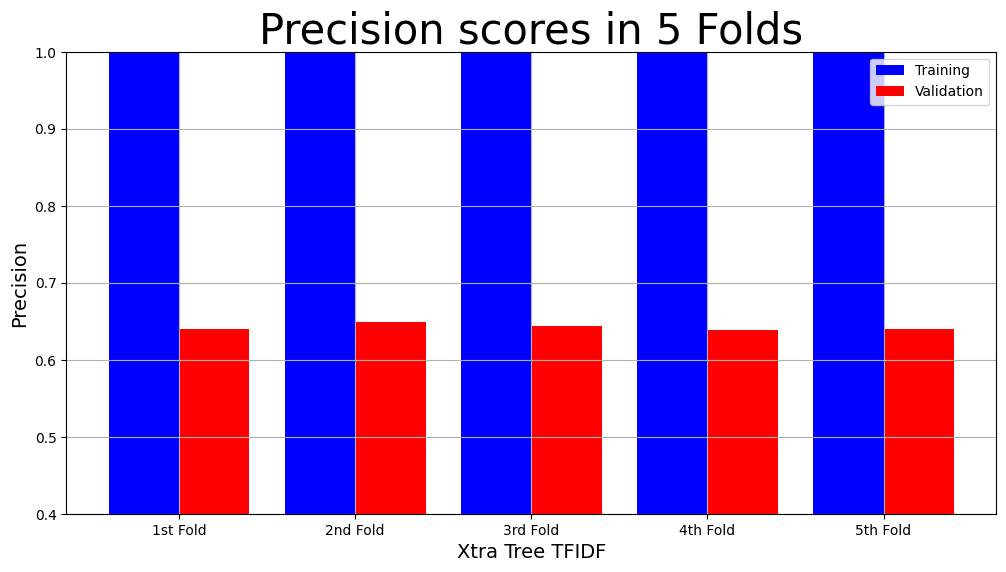

In [46]:
# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            xtree_clf_tfidf_result["Training Precision scores"],
            xtree_clf_tfidf_result["Validation Precision scores"])

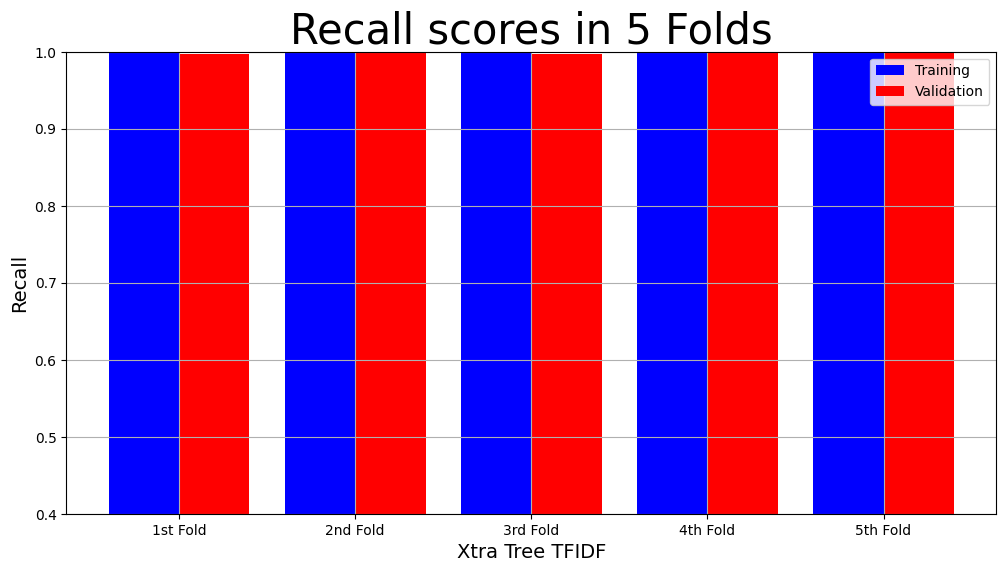

In [47]:
# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            xtree_clf_tfidf_result["Training Recall scores"],
            xtree_clf_tfidf_result["Validation Recall scores"])

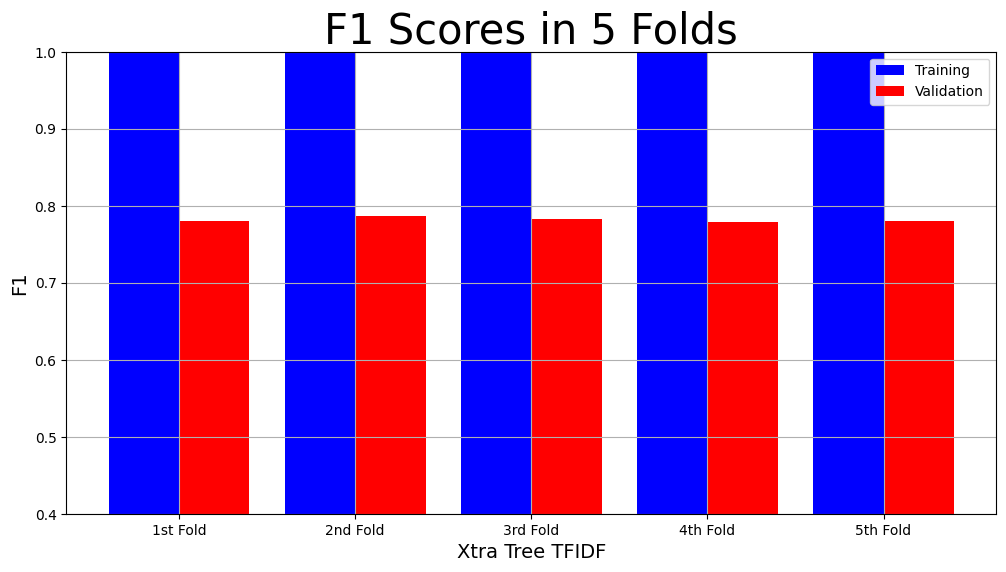

In [48]:
# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            xtree_clf_tfidf_result["Training F1 scores"],
            xtree_clf_tfidf_result["Validation F1 scores"])

### Classification Report 

In [49]:
print(classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       1.00      0.68      0.81      2377
           1       0.64      1.00      0.78      1333

    accuracy                           0.80      3710
   macro avg       0.82      0.84      0.79      3710
weighted avg       0.87      0.80      0.80      3710



### Confusion Matrix 

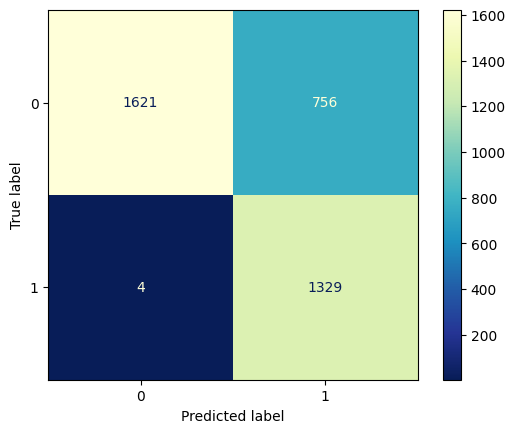

In [50]:
confmatrix = confusion_matrix(y_test_tfidf, y_pred_tfidf)
cm = ConfusionMatrixDisplay(confmatrix, display_labels=["0", "1"])
cm.plot(cmap="YlGnBu_r")
plt.show()

In [51]:
print("Confusion Matrix of our Extratree Classifier", confmatrix)

TP = confmatrix[1,1] # true positive
TN = confmatrix[0,0] # true negatives
FP = confmatrix[0,1] # false positives
FN = confmatrix[1,0] # false negatives

# Let's see the sensitivity of our Extratree Classifier
sensitivity = TP / float(TP+FN)
print("sensitivity of our Extratree Classifier", sensitivity)

# Let us calculate specificity of our Extratree Classifier
specificity = TN / float(TN+FP)
print("specificity of our Extratree Classifier", specificity)

Confusion Matrix of our Extratree Classifier [[1621  756]
 [   4 1329]]
sensitivity of our Extratree Classifier 0.9969992498124531
specificity of our Extratree Classifier 0.6819520403870425


### Saving the Extratree model 

In [52]:
import joblib
  
  
# Save the model as a pickle in a file
joblib.dump(xtree_clf_tfidf, r'/kaggle/working/xtree_clf_tfidf.pkl')
  
# # Load the model from the file
# xtree_clf_from_joblib = joblib.load('/models/xtree_clf.pkl')
  
# # Use the loaded model to make predictions
# xtree_clf_from_joblib.predict(X_test)

['/kaggle/working/xtree_clf_tfidf.pkl']

In [53]:
import pickle

# save the model to disk
filename = '/kaggle/working/xtree_clf_tfidf.sav'
pickle.dump(xtree_clf_tfidf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_tfidf, y_test_tfidf)
print(result)

0.7951482479784366


### Testing of Extratree Classifier model on unknown data

In [ ]:
text=input(" Enter your text for prediction ")

In [ ]:
# print('Vectorized Input:')
v0 = tfidf_vectorizer.transform([text]).toarray()
# print(v0)
pred = xtree_clf_tfidf.predict(v0)
#print("Predicted Output = ",pred)
if pred[0]==0:
    print("It seems to be safe input")
else:
    print("ALERT :::: This can be SQL injection")

### Inverse transform 

In [ ]:
print('To the source:')
print(tfidf_vectorizer.inverse_transform(v0))